In this experiment, we focus at conformers. There is a lot of things to look at here:
1. Does the starting conformation impact the quality of the prediction?
2. Can we use multiple conformers in the training set as data augmention to yield better predictions?
Our goal here is to start from as diverse conformers as possible, with a maximum of five starting conformers per molecule. We might later extend this to more.


confgen_uuid: 11093a30-b6d0-4e3f-a22b-8dcad60d6a11


Conformers were generated using 002_VP_confgen.py. In short, 100 conformers were generated with a diversity pruning of 0.1A, starting from random coordinates. 

In [15]:
#first we get our original conformers
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
sql_query = '''
    SELECT *
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
cur.execute(sql_query)
results = cur.fetchall()
print(len(results))
print(results[0])   
confids = [x[0] for x in results]
molblocks = [x[-3] for x in results]
molregnos = [x[6] for x in results]
print('Checks')
print('-'*30)
print('Confid: ', confids[0])
print('Molregno: ', molregnos[0])
print('Molblock: ',molblocks[0])
print('-'*30)

3019
(2388, 'fc57851e-b654-4338-bcdd-faa28ec66253', {'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540933, 0.39851061882941313, -24.348582835667543, 29.773114168892423, 5.2661979615540035, 29.414383098454888, -36.19785832644828, 6.9291222715587715, -36.0114195778666, -35.96362442571197, 7.861005156060701, -37.1019174745538, 5.409350714799121, 5.120615277516713, 5.08136845690877, -72.16148275216024, 10.52991145898909, -72.40260282291774, 0.2392068971839293, 0.0018383800165236905, 0.23927469491821807, 3.536894, 0.017106198, 3.5361013]'}, '11e1a9f9-393b-4056-852f-d06cf145bd15', 'fc57851e-b654-4338-bcdd-faa28ec66253', 2388, 2390, '-0.281,0.157,-0.303;-1.757,0.179,-0.498;-2.284,1.506,-0.003;-2.427,-0.953,0.272;0.093,0.307,1.115;0.407,-1.019,-0.954;1.387,0.218,1.405;1.883,-0.863,-0.822;2.306,-0.018,0.314;3.505,0.511,0.343', '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM

In [16]:
from rdkit import Chem
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
smiles = [Chem.MolToSmiles(mol) for mol in mols]
#make list of tuples with each tupl containing (molregno, smiles)
molregno_smiles = list(zip(molregnos,smiles))
molregno_smiles[0]
import gzip
import pickle
outfn = 'VP_molregno_smiles.pkl.gz'
with gzip.open(outfn,'wb+') as outf:
    pickle.dump(molregno_smiles,outf)
#this file is used as input for 002_VP_confgen.py

[15:23:06] Warning: molecule is tagged as 3D, but all Z coords are zero


Then 002_VP_confgen.py was ran to generate 100 confs per mol. Next is the picking of 5 diverse ones. 

In [1]:
import glob
import pickle
import gzip

In [2]:
#load the mols
molregnos,mols_all_confs,errors = [],[],[]
for file in glob.glob('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/11093a30-b6d0-4e3f-a22b-8dcad60d6a11/conf_100/11093a30-b6d0-4e3f-a22b-8dcad60d6a11_100.block*.pkl.gz'):
    with gzip.open(file,'rb') as inf:
        ind =pickle.load(inf)
        for mol in ind:
            molregnos.append(mol[0])
            mols_all_confs.append(mol[1])
            errors.append(mol[2])
print(len(molregnos),len(mols_all_confs),len(errors))

3019 3019 3019


621 molecules (20.6%) have only one conformer
310 molecules (10.3%) have 100 conformers


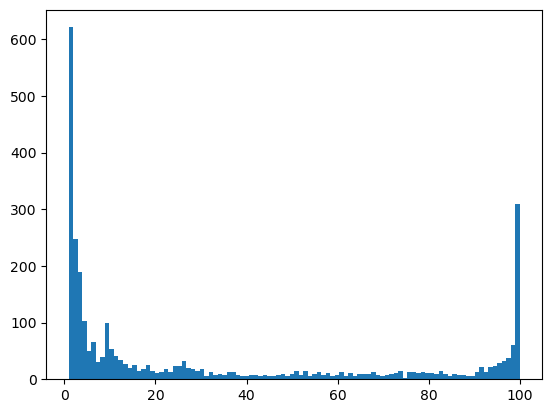

In [48]:
#lets see how many conformers we have
N_confs_all = [m.GetNumConformers() for m in mols_all_confs]
import matplotlib.pyplot as plt
import numpy as np
plt.hist(N_confs_all,bins=100)
print(f'{N_confs_all.count(1)} molecules ({np.round(N_confs_all.count(1)/len(N_confs_all)*100,1)}%) have only one conformer')
print(f'{N_confs_all.count(100)} molecules ({np.round(N_confs_all.count(100)/len(N_confs_all)*100,1)}%) have 100 conformers')
plt.show()

As you can see, it's quite diverse; a fifth of the dataset only has one conformer, while 10% has a big conformation space. 

In [3]:
#to pick the five most diverse conformers, we will use the rdkit MaxMinPicker based on RMS.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

picker = rdSimDivPickers.MaxMinPicker()

def pick_conformers(mol,picks):
    def custom_rmsd_distance(i, j):
        return AllChem.GetBestRMS(mol,mol,i,j)
    selected_indices = list(picker.LazyPick(custom_rmsd_distance, mol.GetNumConformers(), picks, seed=1966))
    mol_X_confs = Chem.Mol(mol)
    mol_X_confs.RemoveAllConformers()
    for i in selected_indices:
        mol_X_confs.AddConformer(mol.GetConformer(i))
    return mol_X_confs

In [ ]:
from tqdm import tqdm
selected_confs_mol_list = []
outfn = '/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/11093a30-b6d0-4e3f-a22b-8dcad60d6a11/conf_5/11093a30-b6d0-4e3f-a22b-8dcad60d6a11_5_100.pkl.gz'
for mol,molregno in tqdm(zip(mols_all_confs,molregnos)):
    mol = Chem.RemoveHs(mol)   #we remove the hydrogens to prevent a combinatory explostion when calculating the RMSD
    if mol.GetNumConformers() > 5:
        picked_mol = pick_conformers(mol,5)
        selected_confs_mol_list.append(picked_mol)
    else:
        selected_confs_mol_list.append(mol)
with gzip.open(outfn,'wb+') as outf:
    pickle.dump(selected_confs_mol_list,outf)

In [22]:
#do some check; load the file
with gzip.open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/11093a30-b6d0-4e3f-a22b-8dcad60d6a11/conf_5/11093a30-b6d0-4e3f-a22b-8dcad60d6a11_mrn_5_100.pkl.gz','rb') as inf:
    loaded_list = pickle.load(inf)
    mols_five_confs = [mol[0] for mol in loaded_list]
print(len(mols_five_confs))
for mol in mols_five_confs[:5]:
    print(mol.GetNumConformers())
    print([conf.GetId() for conf in mol.GetConformers()])

3019
3
[0, 1, 2]
5
[14, 5, 8, 1, 2]
2
[0, 1]
5
[57, 56, 24, 5, 68]
5
[18, 17, 29, 10, 28]


As you can see, the confids are not sequential; this is good, because these correspond to the confids in the original mol (with max 100 conformers). This way, if we would want to add 5 more conformers, we could use the firstpicks options like this:

In [57]:
#as an example, lets get a mol with orignally 100 confs.
example_picking_mol_original = mols_all_confs[N_confs_all.index(100)]
example_picked_mol_original_indices = [conf.GetId() for conf in example_picking_mol_original.GetConformers()]
print(f'Original mol has {example_picking_mol_original.GetNumConformers()} conformers: \n{example_picked_mol_original_indices}')
example_picking_mol_five_confds = mols_five_confs[N_confs_all.index(100)]
example_picked_indices = [conf.GetId() for conf in example_picking_mol_five_confds.GetConformers()]
print(f'We orignally picked {example_picking_mol_five_confds.GetNumConformers()} conformers: \n{example_picked_indices[:5]}')
picker = rdSimDivPickers.MaxMinPicker()

def pick_extra_onformers(mol,picks,first_picks):
    mol = Chem.RemoveHs(mol)
    def custom_rmsd_distance(i, j):
        return AllChem.GetBestRMS(mol,mol,i,j)
    selected_indices = list(picker.LazyPick(custom_rmsd_distance, mol.GetNumConformers(), picks, seed=1966,firstPicks=first_picks))
    mol_X_confs = Chem.Mol(mol)
    mol_X_confs.RemoveAllConformers()
    for i in selected_indices:
        mol_X_confs.AddConformer(mol.GetConformer(i))
    return mol_X_confs
example_picking_mol_10_confds = pick_extra_onformers(example_picking_mol_original,10,example_picked_indices)
example_picked_new_indices = [conf.GetId() for conf in example_picking_mol_10_confds.GetConformers()]
print(f'Now the mols has {example_picking_mol_10_confds.GetNumConformers()} conformers: \n{example_picked_new_indices}')


Original mol has 100 conformers: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
We orignally picked 5 conformers: 
[57, 56, 24, 5, 68]
Now the mols has 10 conformers: 
[57, 56, 24, 5, 68, 31, 85, 30, 73, 13]


In [46]:
#lets see how many conformers we have now
N_confs = [m.GetNumConformers() for m in mols_five_confs]
print(f'{N_confs.count(1)} molecules ({np.round(N_confs.count(1)/len(N_confs)*100,1)}%) have only one conformer')
print(f'{N_confs.count(5)} molecules ({np.round(N_confs.count(5)/len(N_confs)*100,1)}%) have 5 conformers')

621 molecules (20.6%) have only one conformer
1859 molecules (61.6%) have 5 conformers


To register the mols, however, we need to have seperate mols, all with each conformer. 

In [ ]:
#now we need to save these molecules in a sdf file
from tqdm import tqdm
with Chem.SDWriter('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/11093a30-b6d0-4e3f-a22b-8dcad60d6a11/conf_5/11093a30-b6d0-4e3f-a22b-8dcad60d6a11_5_100.sdf') as w:
    for mol in tqdm(mols_five_confs):
        cids = [conf.GetId() for conf in mol.GetConformers()]
        for cid in cids:
            w.write(mol,confId=cid)

In [58]:
#this is one (potentially dumb) way to get the mols with one conf each
mols_five_conf_sup = Chem.SDMolSupplier('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/11093a30-b6d0-4e3f-a22b-8dcad60d6a11/conf_5/11093a30-b6d0-4e3f-a22b-8dcad60d6a11_5_100.sdf',removeHs=False)
mols_five_conf = [mol for mol in mols_five_conf_sup]
print(len(mols_five_conf))

11389


now we can register these new mols

In [ ]:
#lets see what happens if we query for this mol
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [ ]:
#now we can register them
tupp_list =[]
alread_registered = []
for mol in tqdm(mols_five_conf_sup):
    try:
        tupp =lwreg.register(config=config, mol=mol,)
        tupp_list.append(tupp)
    except:
        alread_registered.append(mol)
print(len(tupp_list),len(alread_registered))


In [ ]:
#then register the conf gen metadata
import json
import psycopg2
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
confgen_uuid = '11093a30-b6d0-4e3f-a22b-8dcad60d6a11'
params = {"randomSeed":0xa700f,"verbose":False,"numThreads":4,"trackFailures":True,"useRandomCoords":True,"pruneRmsThresh":0.1,"numConfs":100}
params_json = json.dumps(params)
cur.execute('insert into cs_mdfps_schema.confid_metadata values (%s,%s)',(str(confgen_uuid),str(params_json)))
cn.commit()



In [ ]:
#and the seperate confs
new_confids = [t[1] for t in tupp_list]
#now register all confids in confid_data with confgen_uuid
for confid in new_confids:
    cur.execute('insert into cs_mdfps_schema.confid_data values (%s,%s)',(str(confid),str(confgen_uuid)))
cn.commit()


In [ ]:
#then we need to make the files
#Get the molblocks for these new confids
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('select * from conformers where conf_id in %s',(tuple(new_confids),))
result = cur.fetchall()
print(len(result))
print(result[0])
confdis = [r[0] for r in result]
molblocks = [r[3] for r in result]
for mb,confid in zip(molblocks,confdis):
    print(mb,file=open(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data/mols_3d/{confid}.mol','w+'))

In [ ]:
#finally, we can start the simulations :) lets make a job array
import psycopg2
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('select confid from cs_mdfps_schema.confid_data where confgen_uuid=%s',('11093a30-b6d0-4e3f-a22b-8dcad60d6a11',))
confids = cur.fetchall()
print(len(confids))
print(confids[0])
with open('e0f120fb-efa9-4c88-a964-e7b99253027c.txt','w') as outf:
    for confid in confids:
        confid = confid[0]
        command = f"python mdfp_from_confid.py '{confid}' 'e0f120fb-efa9-4c88-a964-e7b99253027c'"
        outf.write(command+'\n')



In [59]:
#maybe we should also look at some of these confs..
#lets get all molregnos
import psycopg2
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('select molregno from conformers')
molregnos = cur.fetchall()
print(len(molregnos))
print(molregnos[0])
molregnos = [m[0] for m in molregnos]
import random
random.shuffle(molregnos)
print(molregnos[:5])

14455
(2390,)
[4236, 227, 3824, 4030, 2443]


In [62]:
#get the confids for these molregnos
import psycopg2
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
#I like this example, but ofc you can just use a random subset of molregnos
molregnos_example = [2374, 537, 222, 4182, 2951]
cur.execute('select conf_id from conformers where molregno in %s',(tuple(molregnos_example),))
confids = cur.fetchall()
print(len(confids))
print(confids[0])

26
(1367,)


26
(1367, 222, '-0.676,1.08,0.369;-0.776,-0.945,-0.785;-2.212,-1.177,-0.45;-3.287,0.195,-0.423;0.0,-0.12,0.033;0.132,2.235,0.88;1.303,2.8,-0.376;1.389,-0.042,-0.074;1.864,-2.661,-0.71;2.162,-1.259,0.318', '[H]C([H])(Cl)C([H])([H])N(C([H])([H])C([H])([H])Cl)C([H])([H])C([H])([H])Cl\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 9 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 Cl -3.287418 0.195025 -0.423053 0\nM  V30 2 C -2.212101 -1.176532 -0.449636 0\nM  V30 3 C -0.775965 -0.945058 -0.784961 0\nM  V30 4 N 0.000448 -0.119841 0.032823 0\nM  V30 5 C 1.388656 -0.042146 -0.074214 0\nM  V30 6 C 2.162122 -1.259129 0.318123 0\nM  V30 7 Cl 1.863682 -2.660921 -0.709823 0\nM  V30 8 C -0.676013 1.079783 0.369201 0\nM  V30 9 C 0.132106 2.235285 0.880491 0\nM  V30 10 Cl 1.302904 2.799911 -0.375622 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6\nM  V30 6 1 6 7\nM  V30 7 1 4 8\nM  V30 8

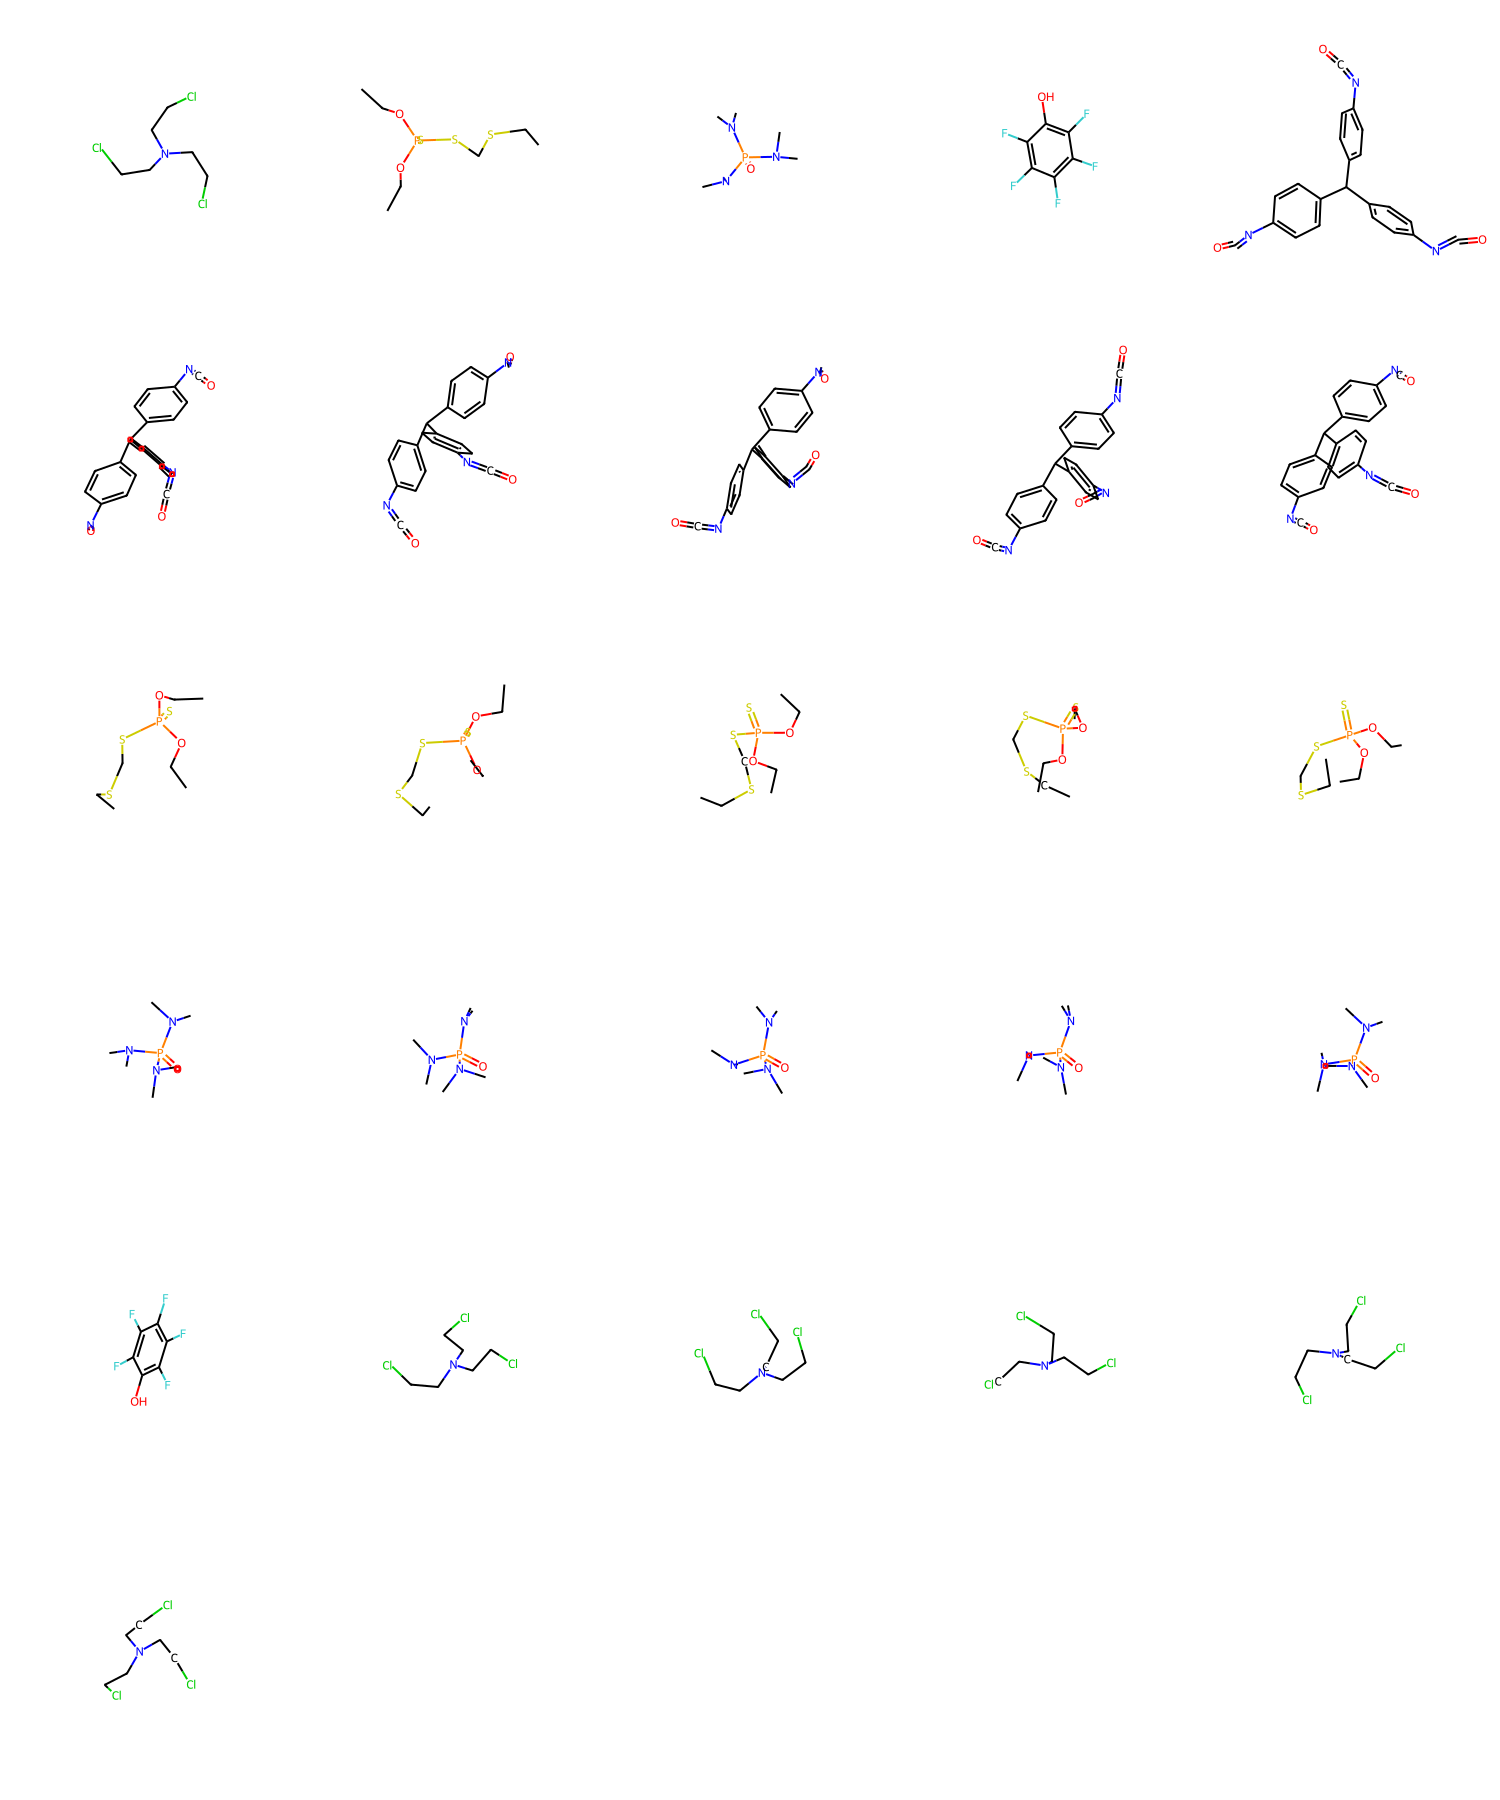

In [63]:
#lets get the molblocks for these
import psycopg2
from rdkit import Chem
from rdkit.Chem import Draw
cn = psycopg2.connect(host='scotland',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('select * from conformers where conf_id in %s',(tuple(confids),))
result = cur.fetchall()
print(len(result))
print(result[0])
confdis = [r[0] for r in result]
molblocks = [r[3] for r in result]
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(300,300))